<a href="https://colab.research.google.com/github/umiSirya/weather_trends/blob/main/Weather_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [331]:
!pip install --upgrade scikit-learn


In [332]:
!pip install --upgrade xgboost


In [333]:
!pip install --upgrade tensorflow


In [334]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import math
import sklearn
import xgboost


import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


# **Getting Weather Data**

In [335]:
import requests
import csv

# API Key
API_KEY = "4091f433030f47658ea85020253001"

# List of major cities in Kenya
kenyan_cities = [
    "Nairobi", "Mombasa", "Kisumu", "Nakuru", "Eldoret", "Malindi", "Thika",
    "Kitale", "Garissa", "Kakamega", "Kericho", "Lamu", "Meru", "Nyeri",
    "Embu", "Voi", "Machakos", "Bomet", "Kisii", "Bungoma", "Siaya",
    "Homa Bay", "Kisumu", "Lodwar", "Taveta", "Kitui", "Murang'a",
    "Isiolo", "Mwingi", "Ruiru", "Kiambu", "Nandi Hills", "Samburu",
    "Chuka", "Kendu Bay", "Wajir", "Mandera", "Marsabit", "Baringo",
    "Taita", "Nyamira", "Laikipia", "Trans Nzoia", "Kajiado"
]

# File name for CSV output
filename = "kenya_weather_data.csv"

# Open CSV file and write headers
with open(filename, mode="w", newline="") as file:
    writer = csv.writer(file)

    # Writing header row
    headers = [
        "City", "Country", "Latitude", "Longitude", "Local Time",
        "Temperature (°C)", "Feels Like (°C)", "Humidity (%)", "Pressure (mb)",
        "Wind Speed (km/h)", "Wind Direction", "UV Index", "Visibility (km)", "Weather Condition",
        "Air Quality Index (US)", "PM2.5", "PM10", "CO (Carbon Monoxide)", "NO2 (Nitrogen Dioxide)", "SO2 (Sulfur Dioxide)",
        "Tomorrow's Max Temp (°C)", "Tomorrow's Min Temp (°C)", "Tomorrow's Condition", "Sunrise", "Sunset"
    ]
    writer.writerow(headers)

    # Loop through each city and fetch weather data
    for city in kenyan_cities:
        try:
            URL = f"http://api.weatherapi.com/v1/forecast.json?key={API_KEY}&q={city}&days=3&aqi=yes"
            response = requests.get(URL)
            data = response.json()

            # Extract comprehensive weather details
            weather_data = [
                data["location"]["name"],
                data["location"]["country"],
                data["location"]["lat"],
                data["location"]["lon"],
                data["location"]["localtime"],

                # Current Weather
                data["current"]["temp_c"],
                data["current"]["feelslike_c"],
                data["current"]["humidity"],
                data["current"]["pressure_mb"],
                data["current"]["wind_kph"],
                data["current"]["wind_dir"],
                data["current"]["uv"],
                data["current"]["vis_km"],
                data["current"]["condition"]["text"],

                # Air Quality Data
                data["current"]["air_quality"].get("us-epa-index", "N/A"),
                data["current"]["air_quality"].get("pm2_5", "N/A"),
                data["current"]["air_quality"].get("pm10", "N/A"),
                data["current"]["air_quality"].get("co", "N/A"),
                data["current"]["air_quality"].get("no2", "N/A"),
                data["current"]["air_quality"].get("so2", "N/A"),

                # Forecast (Next Day)
                data["forecast"]["forecastday"][1]["day"]["maxtemp_c"],
                data["forecast"]["forecastday"][1]["day"]["mintemp_c"],
                data["forecast"]["forecastday"][1]["day"]["condition"]["text"],
                data["forecast"]["forecastday"][1]["astro"]["sunrise"],
                data["forecast"]["forecastday"][1]["astro"]["sunset"],
            ]

            # Write data row
            writer.writerow(weather_data)
            print(f"✅ Weather data for {city} saved.")

        except Exception as e:
            print(f"❌ Error fetching data for {city}: {e}")

print(f"\n🎉 Comprehensive weather data for Kenya saved to {filename} successfully!")


✅ Weather data for Nairobi saved.
✅ Weather data for Mombasa saved.
✅ Weather data for Kisumu saved.
✅ Weather data for Nakuru saved.
✅ Weather data for Eldoret saved.
✅ Weather data for Malindi saved.
✅ Weather data for Thika saved.
✅ Weather data for Kitale saved.
✅ Weather data for Garissa saved.
✅ Weather data for Kakamega saved.
✅ Weather data for Kericho saved.
✅ Weather data for Lamu saved.
✅ Weather data for Meru saved.
✅ Weather data for Nyeri saved.
✅ Weather data for Embu saved.
✅ Weather data for Voi saved.
✅ Weather data for Machakos saved.
✅ Weather data for Bomet saved.
✅ Weather data for Kisii saved.
✅ Weather data for Bungoma saved.
✅ Weather data for Siaya saved.
✅ Weather data for Homa Bay saved.
✅ Weather data for Kisumu saved.
✅ Weather data for Lodwar saved.
✅ Weather data for Taveta saved.
✅ Weather data for Kitui saved.
✅ Weather data for Murang'a saved.
✅ Weather data for Isiolo saved.
✅ Weather data for Mwingi saved.
✅ Weather data for Ruiru saved.
✅ Weather d

In [336]:
# Load the dataset
df = pd.read_csv("kenya_weather_data.csv")
df.head()

,City,Country,Latitude,Longitude,Local Time,Temperature (°C),Feels Like (°C),Humidity (%),Pressure (mb),Wind Speed (km/h),...,PM2.5,PM10,CO (Carbon Monoxide),NO2 (Nitrogen Dioxide),SO2 (Sulfur Dioxide),Tomorrow's Max Temp (°C),Tomorrow's Min Temp (°C),Tomorrow's Condition,Sunrise,Sunset
0,Nairobi,Kenya,-1.2833,36.8167,2025-02-06 19:42,24.4,25.4,44,1018.0,18.4,...,17.945,21.090,501.35,3.330,4.625,26.9,15.3,Patchy rain nearby,06:42 AM,06:52 PM
1,Mombasa,Kenya,-4.0500,39.6667,2025-02-06 19:44,27.2,30.9,74,1007.0,22.0,...,19.240,27.010,247.90,2.035,3.145,30.2,24.3,Patchy rain nearby,06:27 AM,06:43 PM
2,Kisumu,Kenya,-0.1000,34.7500,2025-02-06 19:44,27.4,27.8,39,1011.0,7.2,...,21.275,32.005,423.65,1.480,1.850,29.4,19.6,Patchy rain nearby,06:51 AM,06:59 PM
3,Nakuru,Kenya,-0.2833,36.0667,2025-02-06 19:39,20.6,20.7,34,1009.0,11.2,...,9.435,12.950,305.25,0.740,0.925,27.5,12.3,Sunny,06:46 AM,06:54 PM
4,Eldoret,Kenya,0.5167,35.2833,2025-02-06 19:44,23.1,22.9,41,1020.0,19.8,...,9.065,12.580,283.05,0.925,0.925,27.8,13.3,Sunny,06:50 AM,06:56 PM


# **Exploratory Data Analysis**

In [337]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   City                      42 non-null     object 
 1   Country                   42 non-null     object 
 2   Latitude                  42 non-null     float64
 3   Longitude                 42 non-null     float64
 4   Local Time                42 non-null     object 
 5   Temperature (°C)          42 non-null     float64
 6   Feels Like (°C)           42 non-null     float64
 7   Humidity (%)              42 non-null     int64  
 8   Pressure (mb)             42 non-null     float64
 9   Wind Speed (km/h)         42 non-null     float64
 10  Wind Direction            42 non-null     object 
 11  UV Index                  42 non-null     float64
 12  Visibility (km)           42 non-null     float64
 13  Weather Condition         42 non-null     object 
 14  Air Quality 

In [338]:
df.describe()

,Latitude,Longitude,Temperature (°C),Feels Like (°C),Humidity (%),Pressure (mb),Wind Speed (km/h),UV Index,Visibility (km),Air Quality Index (US),PM2.5,PM10,CO (Carbon Monoxide),NO2 (Nitrogen Dioxide),SO2 (Sulfur Dioxide),Tomorrow's Max Temp (°C),Tomorrow's Min Temp (°C)
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.0,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,-0.649648,36.440771,24.388095,24.802381,46.714286,1011.190476,12.038095,0.314286,10.0,1.476190,17.323929,29.296071,323.926190,1.532857,1.620952,29.071429,16.795238
std,10.599948,26.660281,6.304478,6.452774,16.858501,4.915074,5.747235,1.674569,0.0,0.633923,13.768302,57.487455,85.153746,2.120883,1.531997,5.666818,5.486300
min,-41.200000,-46.850000,-3.800000,-5.100000,11.000000,1005.000000,3.600000,0.000000,10.0,1.000000,7.770000,11.100000,159.100000,0.185000,0.370000,0.400000,-6.800000
25%,-1.254150,34.825025,21.575000,21.575000,39.000000,1008.000000,7.300000,0.000000,10.0,1.000000,11.978750,15.586250,253.912500,0.555000,0.740000,27.725000,14.800000
50%,-0.391700,36.825000,24.400000,25.400000,44.500000,1010.500000,12.050000,0.000000,10.0,1.000000,14.892500,19.147500,296.925000,0.925000,0.925000,29.050000,16.250000
75%,0.333325,37.908300,27.400000,28.100000,55.500000,1015.500000,15.500000,0.000000,10.0,2.000000,19.147500,25.206250,399.600000,1.480000,1.850000,31.300000,19.600000
max,46.766700,174.950000,35.500000,33.800000,83.000000,1025.000000,26.600000,10.600000,10.0,4.000000,99.160000,390.165000,501.350000,11.655000,8.140000,36.500000,25.100000


In [339]:
#checking for null values
df.isnull().sum()

,0
City,0
Country,0
Latitude,0
Longitude,0
Local Time,0
Temperature (°C),0
Feels Like (°C),0
Humidity (%),0
Pressure (mb),0
Wind Speed (km/h),0


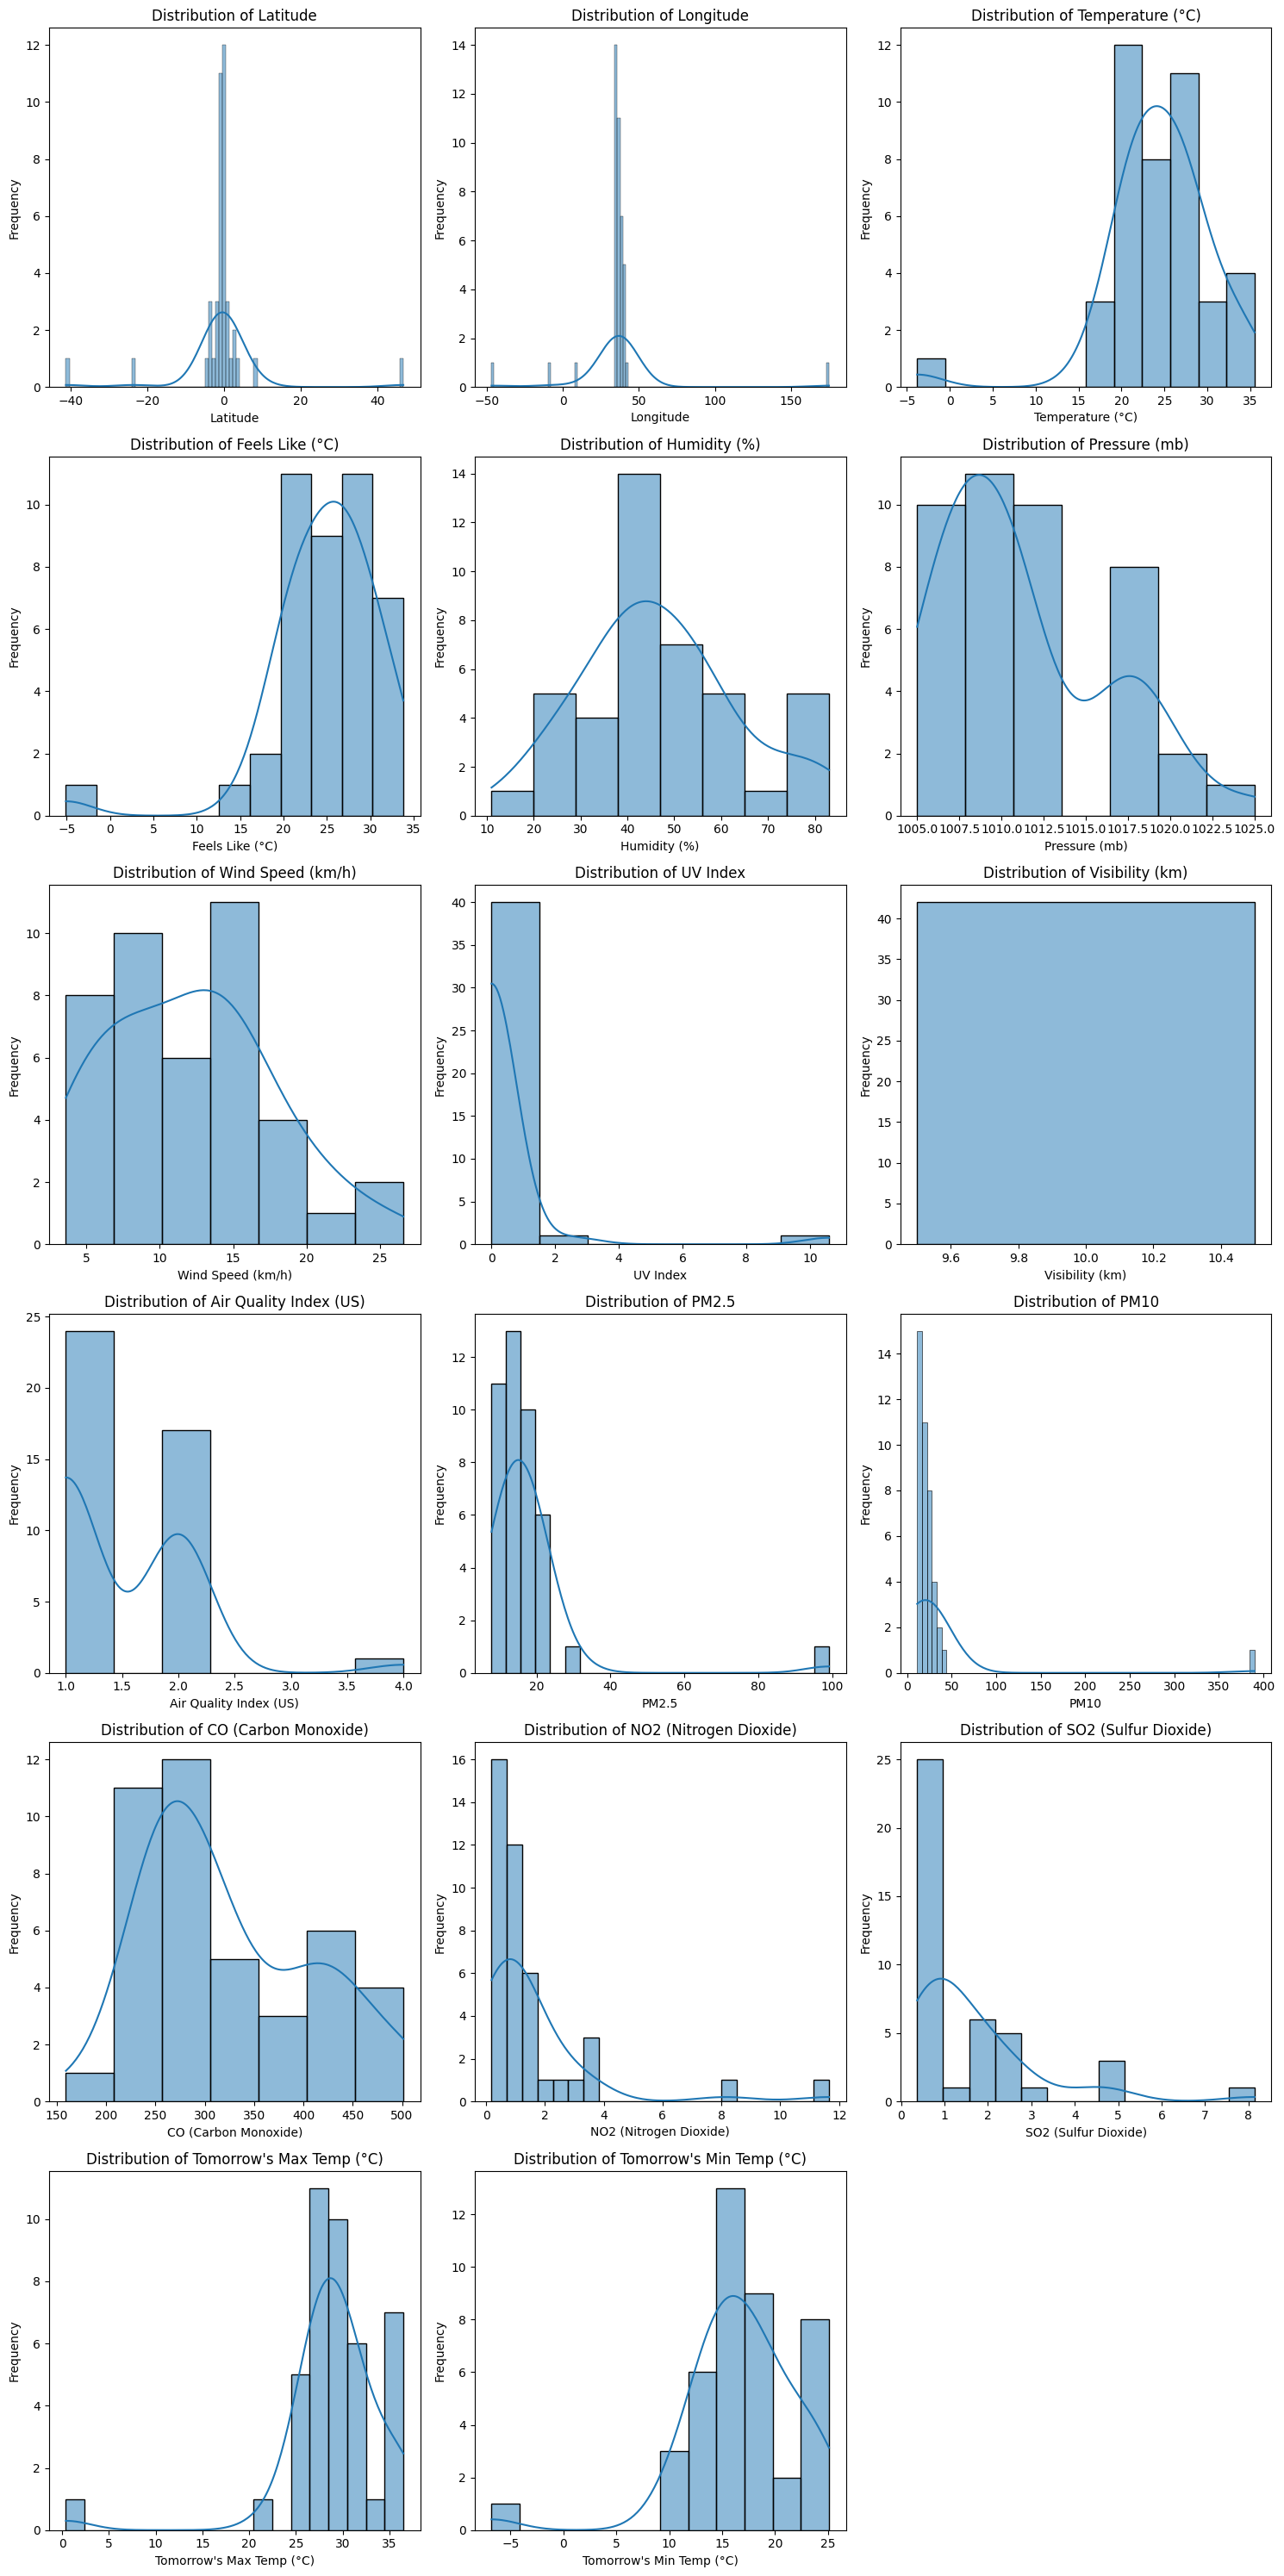

In [340]:
# Number of numerical features
num_features = len(df.select_dtypes(include=['float64', 'int64']).columns)

# Determine the number of rows and columns for the subplots
num_cols = 3
num_rows = math.ceil(num_features / num_cols)

# Plotting the distribution of numerical features
plt.figure(figsize=(15, 5 * num_rows))
for i, col in enumerate(df.select_dtypes(include=['float64', 'int64']).columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()

plt.show()


<ipython-input-341-98f79b260d75>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.



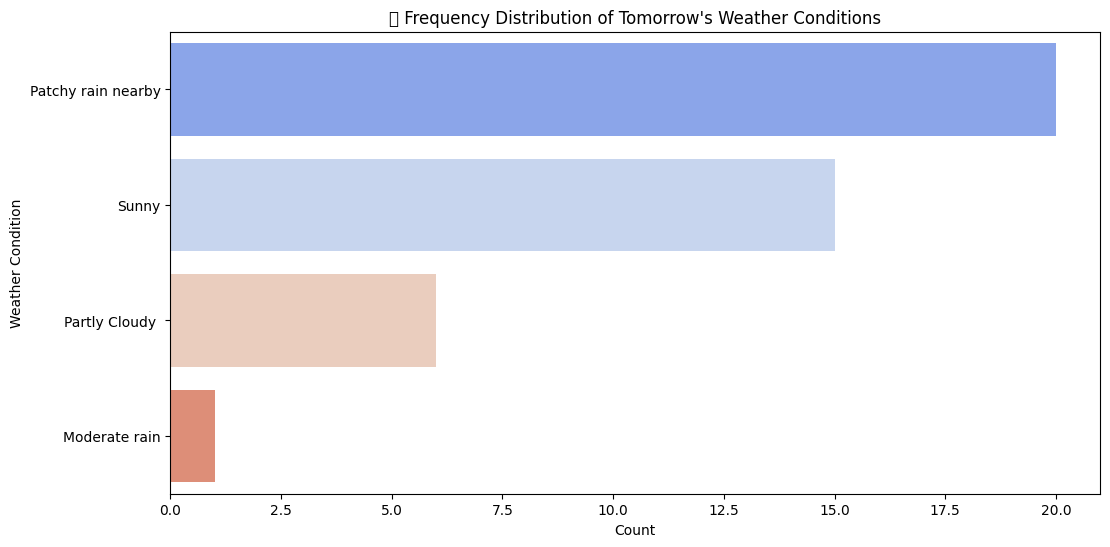

In [341]:
# 🔹 Plot Bar Chart for Tomorrow's Weather Condition
plt.figure(figsize=(12, 6))
sns.countplot(y=df["Tomorrow's Condition"], order=df["Tomorrow's Condition"].value_counts().index, palette="coolwarm")
plt.xlabel("Count")
plt.ylabel("Weather Condition")
plt.title("📌 Frequency Distribution of Tomorrow's Weather Conditions")
plt.show()

In [342]:
df['Weather Condition'].value_counts()

,count
Weather Condition,
Partly cloudy,19
Clear,15
Partly Cloudy,3
Patchy rain nearby,3
Sunny,1
Cloudy,1


# **Visualizations**

In [343]:
# 🔹 Geospatial Map of Cities
fig = px.scatter_mapbox(df, lat="Latitude", lon="Longitude", color="Temperature (°C)", size="Wind Speed (km/h)", mapbox_style="open-street-map", title="🌎 Temperature Across Kenya")
fig.show()

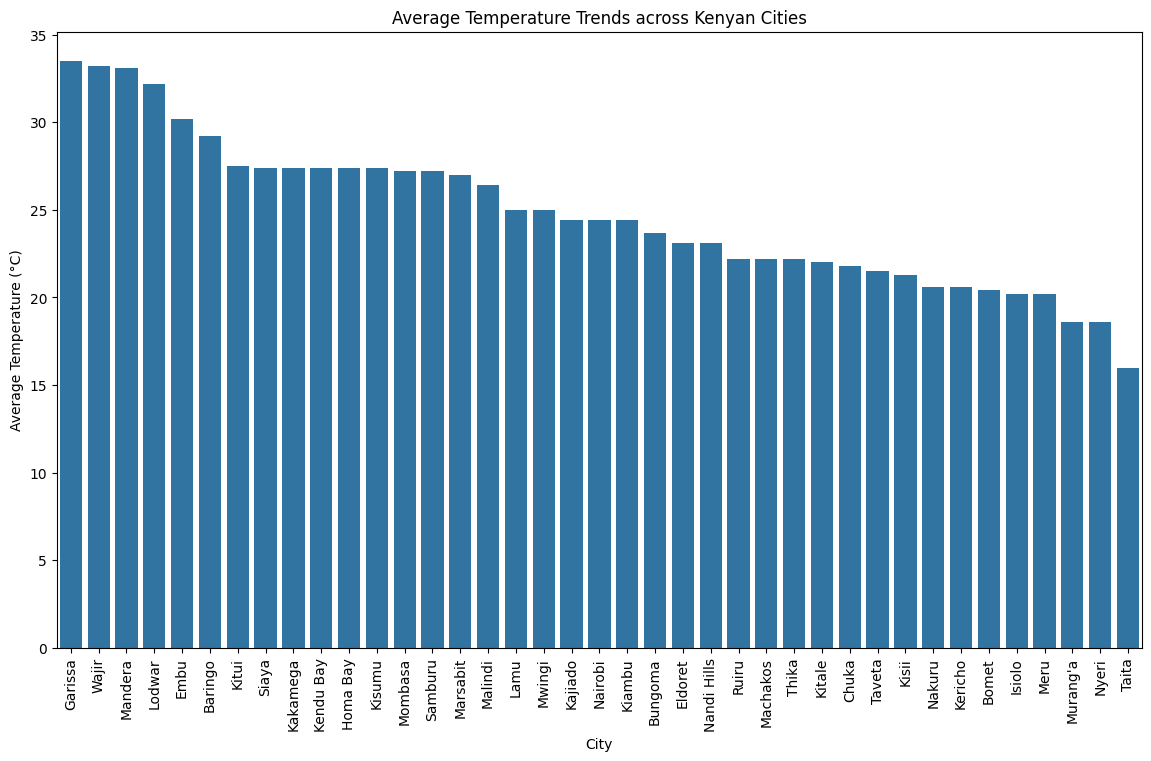

In [344]:
# Filter the DataFrame to include only the specified cities
df_filtered = df[df['City'].isin(kenyan_cities)]

# Calculate the average temperature for each city
avg_temp_by_city = df_filtered.groupby('City')['Temperature (°C)'].mean().reset_index()

# Sort the DataFrame by temperature in descending order
avg_temp_by_city = avg_temp_by_city.sort_values(by='Temperature (°C)', ascending=False)

# Vertical Bar Graph for Temperature Trends across Kenyan Cities
plt.figure(figsize=(14, 8))
sns.barplot(x='City', y='Temperature (°C)', data=avg_temp_by_city)
plt.title('Average Temperature Trends across Kenyan Cities')
plt.xlabel('City')
plt.ylabel('Average Temperature (°C)')
plt.xticks(rotation=90)
plt.show()

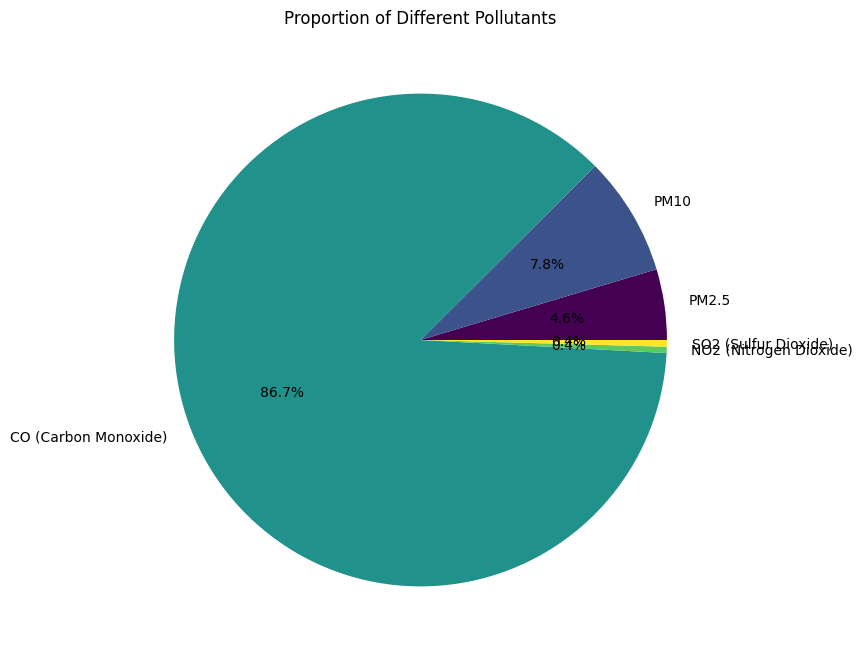

In [345]:
# Pie Chart for Pollutants
pollutants = ['PM2.5', 'PM10', 'CO (Carbon Monoxide)', 'NO2 (Nitrogen Dioxide)', 'SO2 (Sulfur Dioxide)']
pollutant_totals = df[pollutants].mean()

plt.figure(figsize=(8, 8))
plt.pie(pollutant_totals, labels=pollutants, autopct='%1.1f%%', colors=cm.viridis(np.linspace(0, 1, len(pollutants))))
plt.title('Proportion of Different Pollutants')
plt.show()

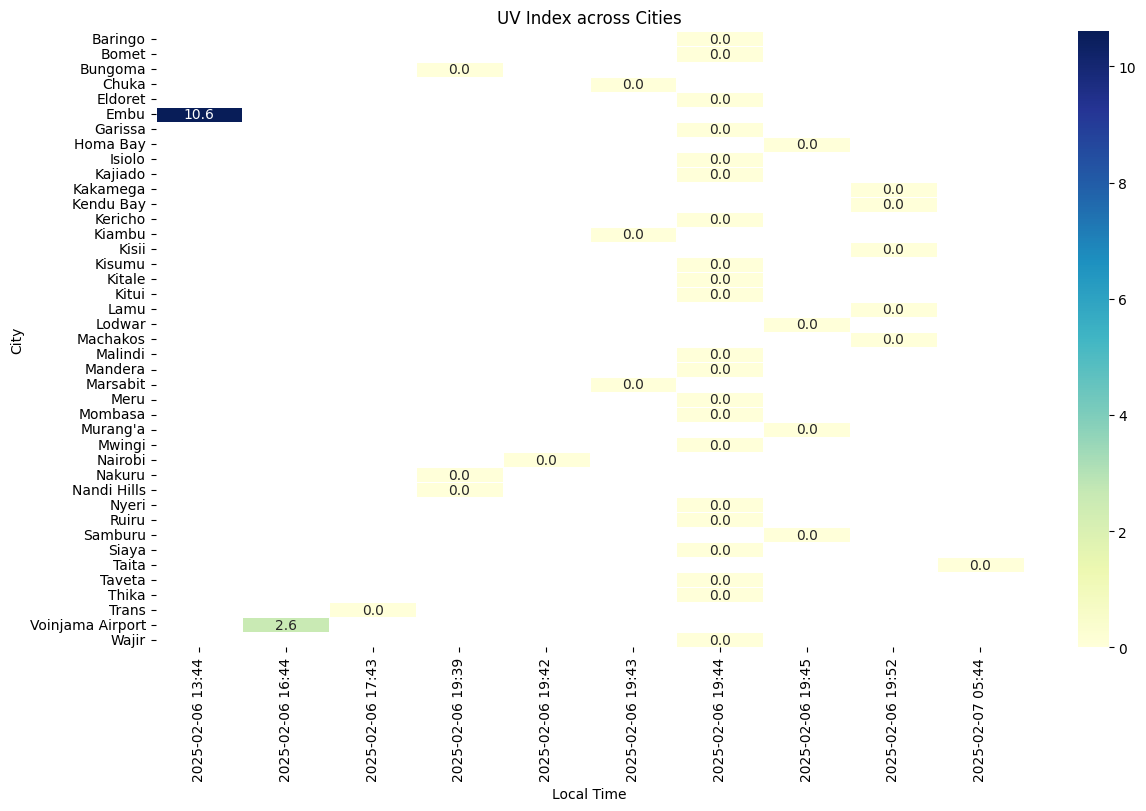

In [346]:

# Create a pivot table for the heatmap
pivot_table = df.pivot_table(values='UV Index', index='City', columns='Local Time', aggfunc='mean')

# Heatmap for UV Index across Cities
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt=".1f", linewidths=0.5)
plt.title('UV Index across Cities')
plt.xlabel('Local Time')
plt.ylabel('City')
plt.xticks(rotation=90)
plt.show()


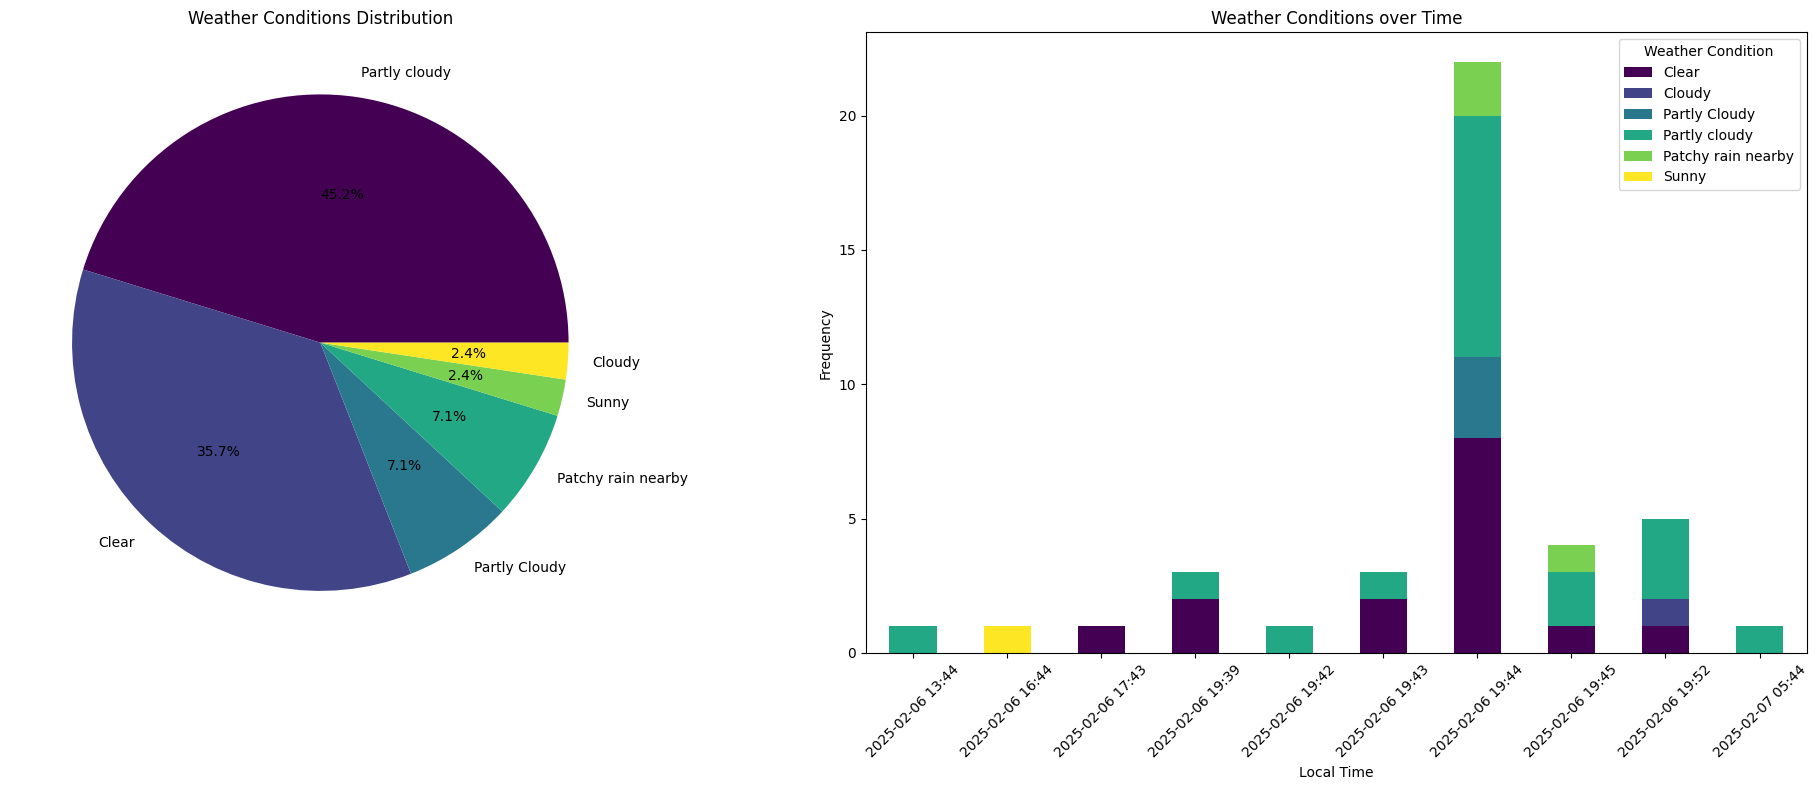

In [347]:
# Pie Chart for Weather Conditions
weather_conditions = df['Weather Condition'].value_counts()

# Stacked Bar Chart for Weather Conditions over Time
weather_time = pd.crosstab(df['Local Time'], df['Weather Condition'])

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Pie Chart
axes[0].pie(weather_conditions, labels=weather_conditions.index, autopct='%1.1f%%',
            colors=plt.cm.viridis(np.linspace(0, 1, len(weather_conditions))))
axes[0].set_title('Weather Conditions Distribution')

# Stacked Bar Chart for Weather Conditions over Time
weather_time.plot(kind='bar', stacked=True, ax=axes[1], colormap='viridis')
axes[1].set_title('Weather Conditions over Time')
axes[1].set_xlabel('Local Time')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Weather Condition')

plt.tight_layout()
plt.show()


# **Data Pre-processing**

In [348]:
# make a copy of the df
df_copy = df.copy()
df_copy1=df_copy.copy()

In [349]:
# List of columns to drop (including "Weather Condition")
columns_to_drop = [
    "PM2.5", "PM10", "CO (Carbon Monoxide)",
    "NO2 (Nitrogen Dioxide)", "SO2 (Sulfur Dioxide)", "Air Quality Index (US)",
    "City", "Country", "Latitude", "Longitude",
    "Local Time", "Visibility (km)", "Weather Condition", "Tomorrow's Condition", "Wind Direction"
]

# Drop unnecessary columns
df_copy.drop(columns=columns_to_drop, inplace=True)

# Convert 'Sunrise' and 'Sunset' to numerical features (minutes since midnight)
df_copy['Sunrise'] = pd.to_datetime(df_copy['Sunrise'], format='%I:%M %p').dt.hour * 60 + pd.to_datetime(df_copy['Sunrise'], format='%I:%M %p').dt.minute
df_copy['Sunset'] = pd.to_datetime(df_copy['Sunset'], format='%I:%M %p').dt.hour * 60 + pd.to_datetime(df_copy['Sunset'], format='%I:%M %p').dt.minute

# Reset index
df_copy.reset_index(drop=True, inplace=True)

# Separate target variable
uv_index = df_copy['UV Index']

# Normalize numerical features (excluding 'UV Index')
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_copy.drop(columns=['UV Index']))

# Convert scaled features back to a DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=df_copy.columns[df_copy.columns != 'UV Index'])

# Add 'UV Index' back
scaled_df['UV Index'] = uv_index.values



**Creating sequences for the LSTM model**

In [350]:
# Define a function to create sequences
def create_sequences(data, target_column, seq_length=30):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i+seq_length].drop(columns=[target_column]).values
        target = data.iloc[i+seq_length][target_column]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Create sequences for LSTM
seq_length = 30
X, y = create_sequences(df_copy, 'UV Index', seq_length)



In [351]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Temperature (°C)          42 non-null     float64
 1   Feels Like (°C)           42 non-null     float64
 2   Humidity (%)              42 non-null     int64  
 3   Pressure (mb)             42 non-null     float64
 4   Wind Speed (km/h)         42 non-null     float64
 5   UV Index                  42 non-null     float64
 6   Tomorrow's Max Temp (°C)  42 non-null     float64
 7   Tomorrow's Min Temp (°C)  42 non-null     float64
 8   Sunrise                   42 non-null     int32  
 9   Sunset                    42 non-null     int32  
dtypes: float64(7), int32(2), int64(1)
memory usage: 3.1 KB


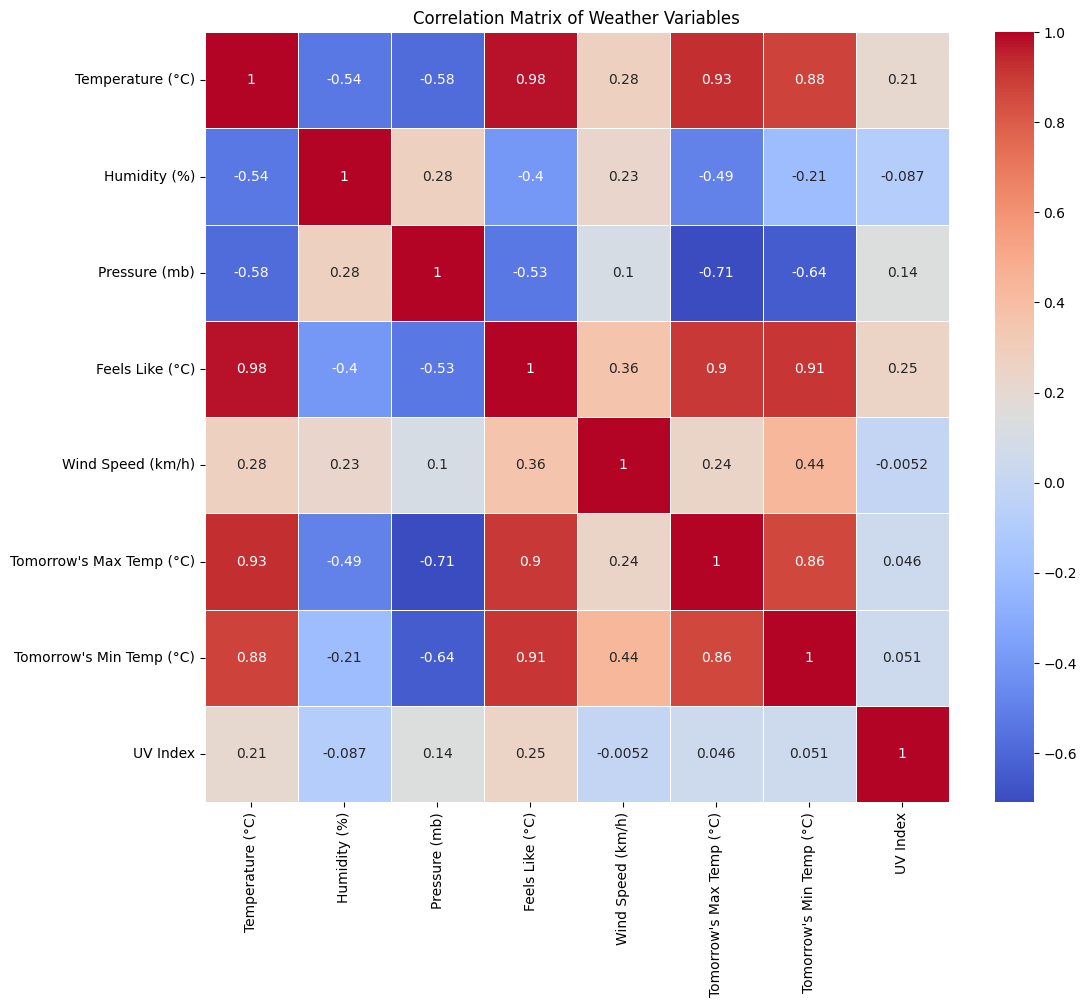

In [352]:
# correlation Heatmap

# Define relevant columns
col = [
    'Temperature (°C)', 'Humidity (%)', 'Pressure (mb)', 'Feels Like (°C)',
    'Wind Speed (km/h)', "Tomorrow's Max Temp (°C)",
    "Tomorrow's Min Temp (°C)", "UV Index"
]

# Apply preprocessing to numerical columns for correlation analysis
numerical_data = df_copy[col]  # Select numerical data

numerical_transformer = StandardScaler()  # Initialize scaler
numerical_data_scaled = numerical_transformer.fit_transform(numerical_data)  # Scale data

# Convert scaled data back into a DataFrame
numerical_data_scaled_df = pd.DataFrame(numerical_data_scaled, columns=col)

# Calculate the correlation matrix
correlation_matrix = numerical_data_scaled_df.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Weather Variables')
plt.show()


**Train-Test split**

In [353]:
# Split data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



# **Modelling**

**LSTM**

In [354]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, X.shape[2]), return_sequences=True))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')




/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 67231.9219 - val_loss: 13217.4473
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 37776.8359 - val_loss: 72616.9375
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 43905.4609 - val_loss: 76557.3672
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - loss: 64955.4180 - val_loss: 70874.2500
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 65797.9609 - val_loss: 52206.4141
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 113621.3594 - val_loss: 95869.2578
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - loss: 106914.5234 - val_loss: 115598.3125
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step - loss: 109462.3984 - val_loss: 115656.6484
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 74219.0391 - val_loss: 122345.8828
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step - loss: 63991.2734 - val_loss: 261217.0625
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 160

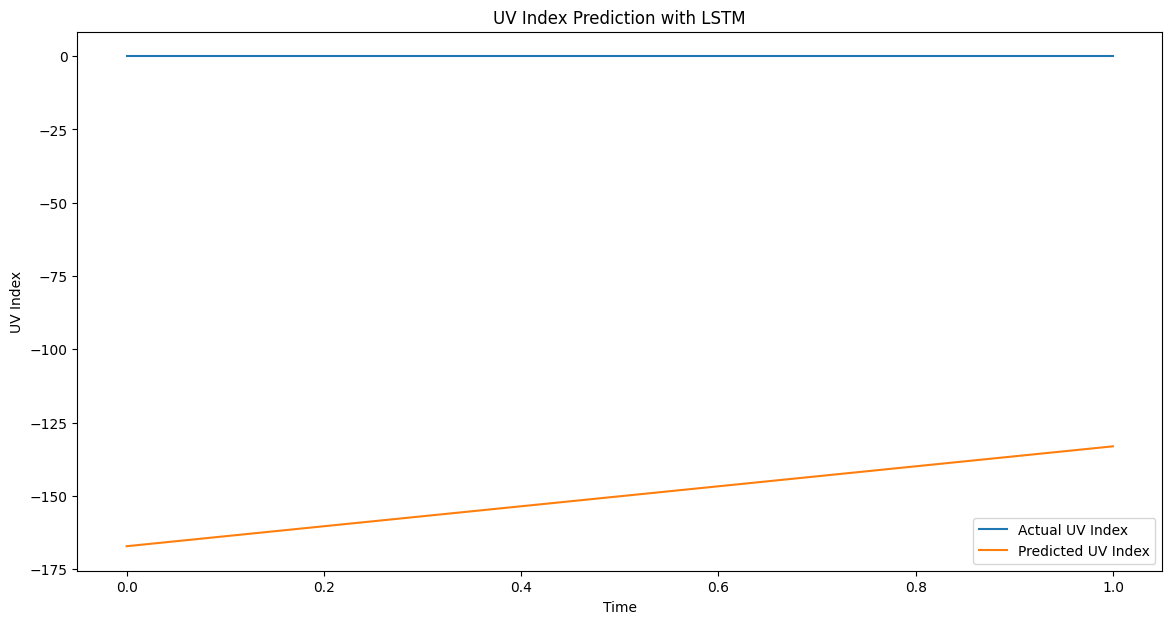

In [355]:
# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate the model
mse = model.evaluate(X_test, y_test)
print(f'Test Mean Squared Error: {mse}')

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values if necessary
y_test_inverse = y_test  # If you need to inverse transform, use scaler.inverse_transform or a similar method
y_pred_inverse = y_pred  # Apply inverse transformation if scaling was applied to target

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_inverse, label='Actual UV Index')
plt.plot(y_pred_inverse, label='Predicted UV Index')
plt.legend()
plt.title('UV Index Prediction with LSTM')
plt.xlabel('Time')
plt.ylabel('UV Index')
plt.show()

**Hyperparameter Tuning using Randomized Search**

In [356]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.optimizers import Adam

# Function to create the LSTM model
def create_lstm_model(optimizer='adam', units=50, dropout_rate=0.2, activation='relu'):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))

    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Custom wrapper class to use Keras with scikit-learn's RandomizedSearchCV
class KerasClassifierCustom(BaseEstimator, ClassifierMixin):
    def __init__(self, build_fn=None, optimizer='adam', units=50, dropout_rate=0.2, activation='relu', epochs=10, batch_size=32):
        self.build_fn = build_fn
        self.optimizer = optimizer
        self.units = units
        self.dropout_rate = dropout_rate
        self.activation = activation
        self.epochs = epochs
        self.batch_size = batch_size

    def fit(self, X, y, **kwargs):
        # Create model
        self.model = self.build_fn(optimizer=self.optimizer, units=self.units,
                                    dropout_rate=self.dropout_rate, activation=self.activation)
        # Fit model with epochs and batch_size passed from search
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, **kwargs)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        return self.model.evaluate(X, y)

# Wrap the model for use with RandomizedSearchCV
model = KerasClassifierCustom(build_fn=create_lstm_model)

# Define the hyperparameter grid to search, including epochs and batch_size
param_dist = {
    'epochs': [10, 20, 50],
    'batch_size': [32, 64, 128],
    'optimizer': ['adam', 'rmsprop'],
    'units': [50, 100, 200],
    'dropout_rate': [0.2, 0.3, 0.5],
    'activation': ['relu', 'tanh', 'sigmoid']
}

# Perform Randomized Search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=5, cv=3, verbose=2, n_jobs=-1)
random_search_result = random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search_result.best_params_
print(f"Best Hyperparameters: {best_params}")

# Train the model with the best hyperparameters
best_model = random_search_result.best_estimator_

# Evaluate the model on validation/test data
score = best_model.score(X_val, y_val)
print(f"Model evaluation score: {score}")


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2042
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1268
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1419
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0809
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0728
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.1425
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.3201
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0541
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.1026
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1848
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0760
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2353
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0603
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0442
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Mean Squared Error (MSE): 0.01017747393842311
R-squared (R²): 0.0


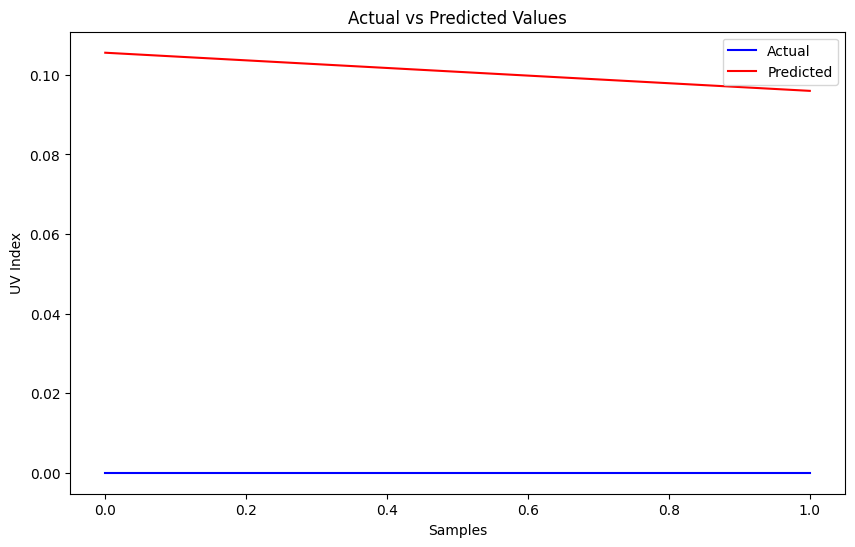

In [357]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Perform Randomized Search and get the best model as before

# Predict with the best model
y_pred = best_model.predict(X_val)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_val, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate R-squared (R²)
r2 = r2_score(y_val, y_pred)
print(f"R-squared (R²): {r2}")

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(y_val, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Samples')
plt.ylabel('UV Index')
plt.legend()
plt.show()


**Random Forest**

In [358]:
# # Train the Random Forest Regressor
# rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
# rf_model.fit(X_train_preprocessed, y_train)

In [359]:
# # Make predictions on the validation set
# y_val_pred_rf = rf_model.predict(X_val_preprocessed)

# # Evaluate the models on the validation set
# mse_rf = mean_squared_error(y_val, y_val_pred_rf)
# r2_rf = r2_score(y_val, y_val_pred_rf)

# print(f'Random Forest - Mean Squared Error: {mse_rf}, R^2 Score: {r2_rf}')

**XGBoost Regressor/Gradient Boosting Machines**

In [360]:
# Train the XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_preprocessed, y_train)

NameError: name 'XGBRegressor' is not defined

In [ ]:
# One hot encode tomorrows condition column
df = pd.get_dummies(df, columns=["Tomorrow's Condition"])
